In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits as mp
import seaborn as sns
import src.make_data as generate
import src.plots as plot
import csv
from sklearn.ensemble import GradientBoostingClassifier
from src.model import Model
import src.pipeline as pipeline
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import geopandas as gpd

%matplotlib inline
plt.style.use('ggplot')

In [2]:
%load_ext autoreload
%autoreload 2

In [68]:
df = pd.read_csv('data/merged_data.csv')


In [57]:
df = df.drop(['latitude_y', 'longitude_y', 'station', 'date', 'month_y', 'doy', 'year'],
                              axis=1)

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33486 entries, 0 to 33485
Data columns (total 30 columns):
fire_year           33486 non-null int64
discovery_date      33486 non-null float64
discovery_doy       33486 non-null int64
discovery_time      21081 non-null float64
stat_cause_code     33486 non-null float64
stat_cause_descr    33486 non-null object
cont_date           21338 non-null float64
cont_doy            21338 non-null float64
cont_time           20657 non-null float64
fire_size           33486 non-null float64
fire_size_class     33486 non-null object
latitude_x          33486 non-null float64
longitude_x         33486 non-null float64
state               33486 non-null object
county              23220 non-null object
fips_code           23220 non-null float64
fips_name           23220 non-null object
date_start          33486 non-null object
month_x             33486 non-null int64
date_end            21338 non-null object
length              21338 non-null float64
w

In [60]:
df['date_start'] = pd.to_datetime(df['date_start'])
df['date_end'] = pd.to_datetime(df['date_end'])


In [59]:
df.to_csv('data/merged_data.csv', index=False)

### Cause of Fire EDA

In [7]:
def group_cause(cause):
    
    human_activity = ['Debris Burning', 'Campfire', 'Arson', 'Children', 'Fireworks', 'Smoking', 'Equipment Use']
    other = ['Missing/Undefined', 'Powerline', 'Railroad', 'Structure', 'Lightning', 'Miscellaneous']
    #nature = ['Lightning']
    
    if cause in human_activity: 
        return 'human'
    elif cause in other:
        return 'other'
    

In [8]:
df['cause_group'] = np.vectorize(group_cause)(df['stat_cause_descr'])

In [25]:
cause_groupby = df.groupby('stat_cause_descr')
cause_group_grouby = df.groupby('cause_group')

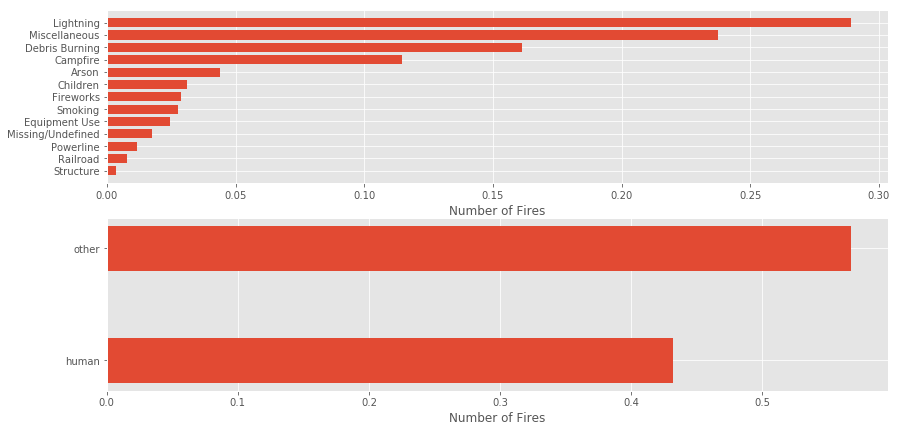

In [26]:
fig, axs = plt.subplots(2,1, figsize=(14,7))

cause_counts = cause_groupby.count().sort_values('fire_year', ascending=True)
total_fires = cause_counts.iloc[:,1].values.sum()
axs[0].barh(np.linspace(0,13,13), cause_counts['stat_cause_code']/total_fires, tick_label=cause_counts.index)
axs[0].set_xlabel('Number of Fires')

cause_group_counts = cause_group_grouby.count().sort_values('fire_year', ascending=True)
axs[1].barh(np.linspace(0,2,2), cause_group_counts['stat_cause_code']/total_fires, tick_label=cause_group_counts.index)
axs[1].set_xlabel('Number of Fires')


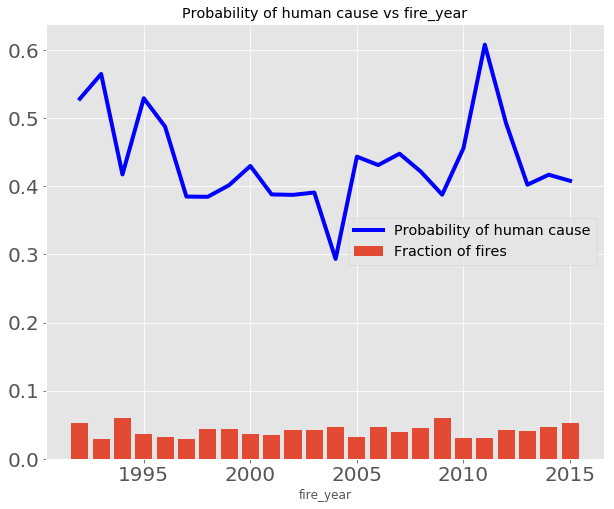

In [27]:
fig, ax = plt.subplots(figsize=(10,8))
plot.univariate_plot('fire_year', ax, df)

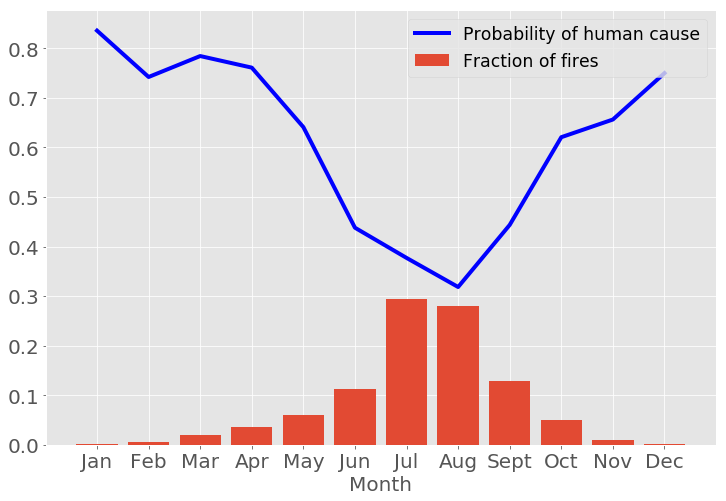

In [163]:
fig, ax = plt.subplots(figsize=(12,8))
plot.univariate_plot('month_x', ax, df)
#ax.set_title('Probability of Human Cause vs. Month', fontsize=24)
ax.set_title('')
months = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct','Nov', 'Dec' ]
ax.set_xlabel('Month', fontsize=20)
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(months)
fig.savefig('images/month_univariate')
ax.legend(fontsize='xx-large', loc=1)

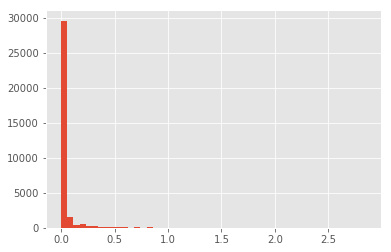

In [88]:
df['prcp'].hist(bins=50)

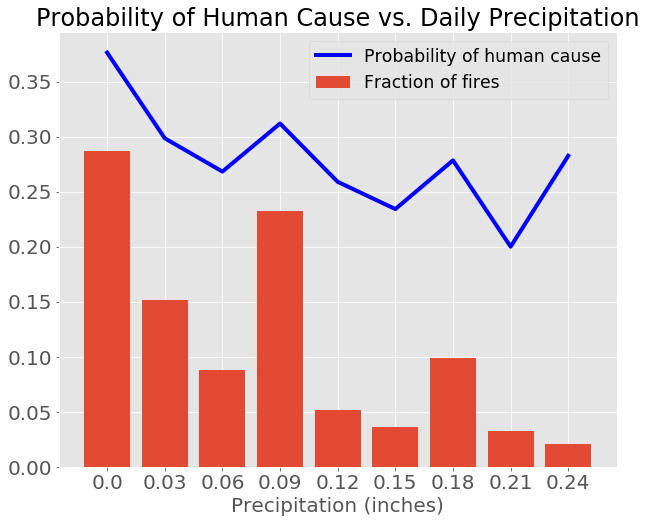

In [29]:
fig, ax = plt.subplots(figsize=(10,8))

prcp_bins = np.arange(0,0.3,0.03)
_ = plot.univariate_binned_plot(prcp_bins,'prcp', ax, df)

ax.set_title('Probability of Human Cause vs. Daily Precipitation', fontsize=24)
ax.set_xlabel('Precipitation (inches)', fontsize=20)
fig.savefig('images/prcp_univariate')

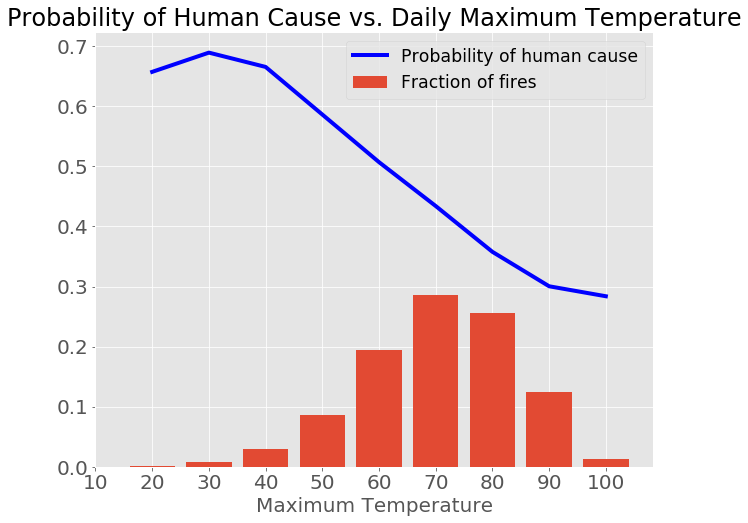

In [30]:
fig, ax = plt.subplots(figsize=(10,8))

tmax_bins = np.arange(10,120,10)
_ = plot.univariate_binned_plot(tmax_bins,'tmax', ax, df)

ax.set_title('Probability of Human Cause vs. Daily Maximum Temperature', fontsize=24)
ax.set_xlabel('Maximum Temperature', fontsize=20)
fig.savefig('images/tmax_univariate')


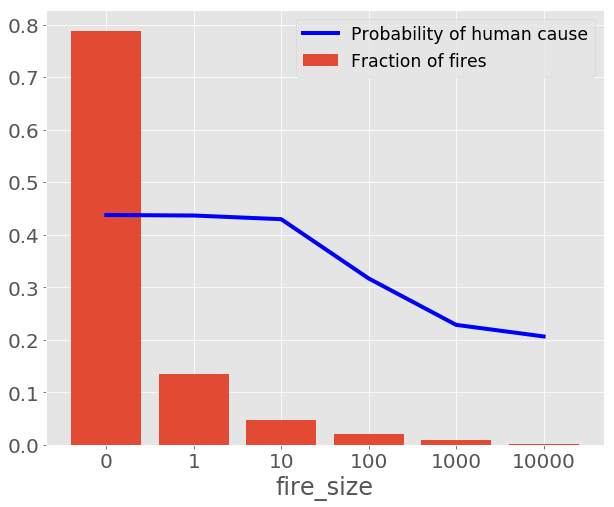

In [31]:
fig, ax = plt.subplots(figsize=(10,8))

fire_size_bins = np.array([0,1,10,100,1000,10000,30000])
_ = plot.univariate_binned_plot(fire_size_bins,'fire_size', ax, df)


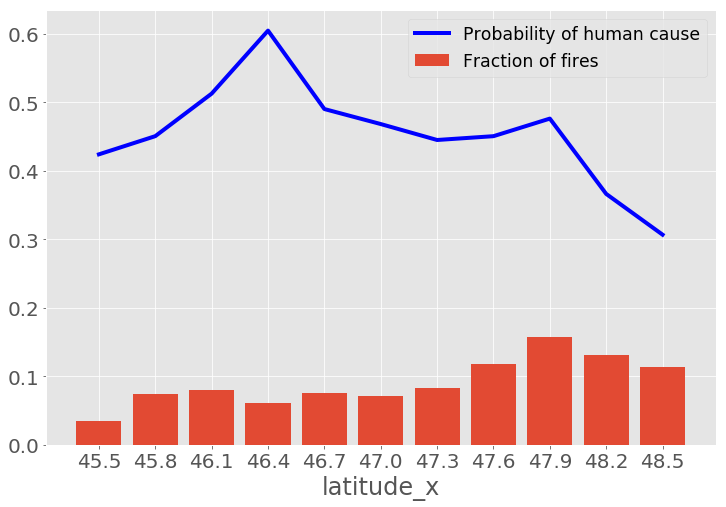

In [54]:
fig, ax = plt.subplots(figsize=(12,8))

lat_bins = np.arange(45.5,49, 0.3)
_ = plot.univariate_binned_plot(lat_bins,'latitude_x', ax, df)


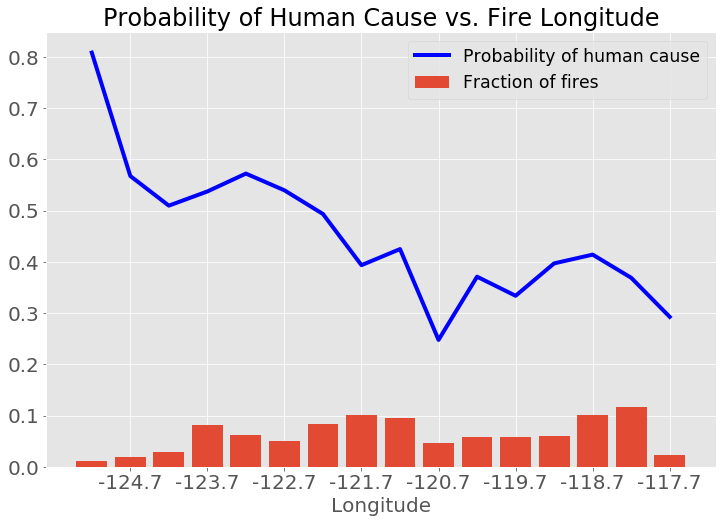

In [60]:
fig, ax = plt.subplots(figsize=(12,8))

long_bins = np.arange(-124.7,-116.5, 0.5)
_ = plot.univariate_binned_plot(long_bins,'longitude_x', ax, df)

ax.set_xticks(np.arange(1,len(long_bins), 2))
ax.set_xticklabels(np.arange(-124.7,-116.5, 1))
ax.set_title('Probability of Human Cause vs. Fire Longitude', fontsize=24)
ax.set_xlabel('Longitude', fontsize=20)
fig.savefig('images/longitude_univariate')

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

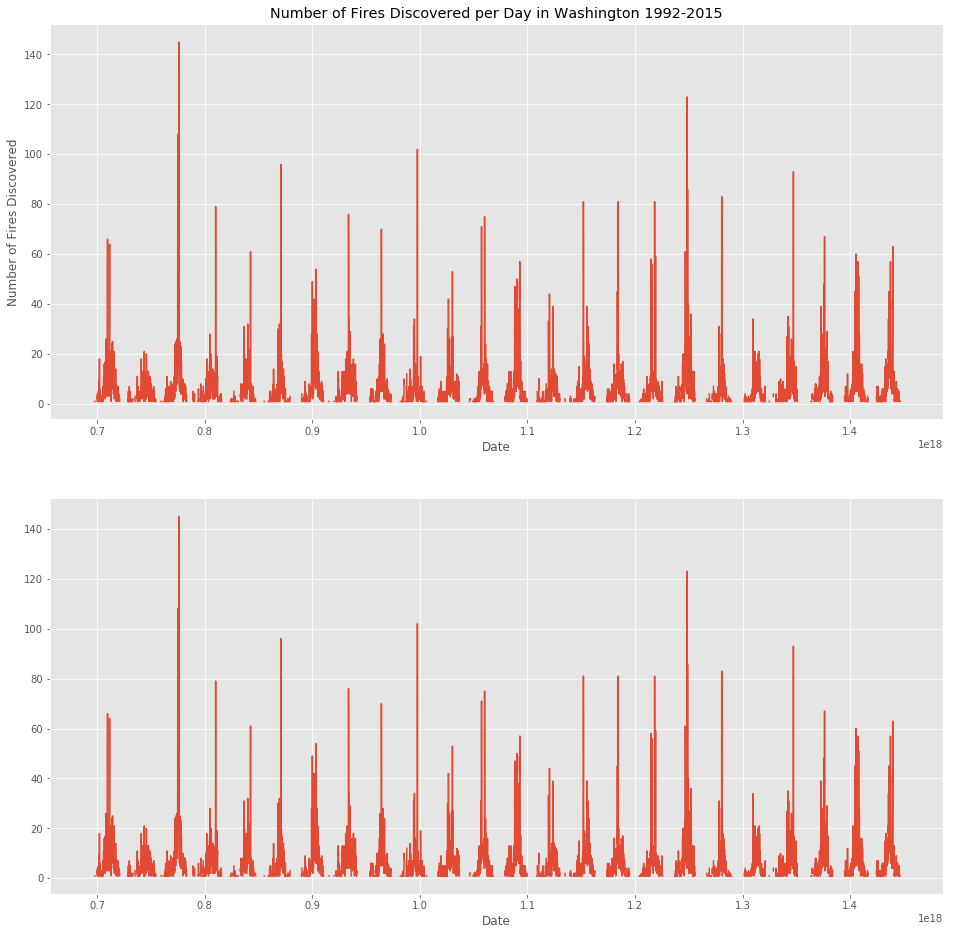

In [61]:
# Time series plots
index = pd.date_range(df["date_start"].min(), df["date_start"].max())
groupby_date = df.groupby("date_start")
count_timeseries = pd.Series(data = groupby_date['fire_year'].count(), index=index)

fig, axs = plt.subplots(2,1,figsize=(16,16))

axs[0].plot(count_timeseries.index, count_timeseries.values)
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Number of Fires Discovered')
axs[0].set_title('Number of Fires Discovered per Day in Washington 1992-2015')

axs[1].plot(count_timeseries.index, count_timeseries.values)
axs[1].set_xlabel('Date')
axs[1].set_xlim((pd.Timestamp('2010-01-01 00:00:00'), pd.Timestamp('2015-11-27 00:00:00')))
#axs[1].set_xlim('2010-01-01 00:00:00', '2015-11-27 00:00:00')
axs[1].set_ylim(-5,50)
axs[1].set_ylabel('Number of Fires Discovered')
axs[1].set_title('Number of Fires Discovered per Day in Washington 2010-2015')


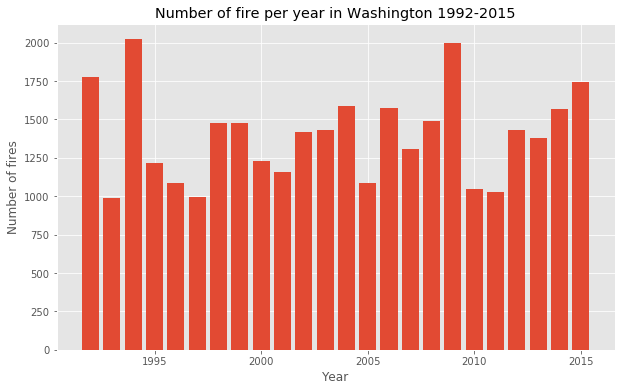

In [62]:
year_count = df.groupby('fire_year').count()['state']

fig, ax = plt.subplots(figsize=(10,6))

ax.bar(year_count.index, year_count.values)
ax.set_xlabel('Year')
ax.set_ylabel('Number of fires')
ax.set_title("Number of fire per year in Washington 1992-2015")

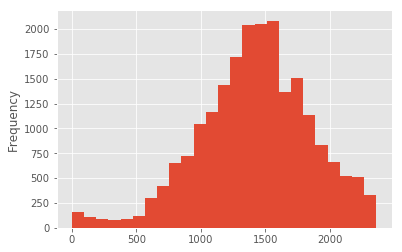

In [134]:
df['discovery_time'].plot(kind='hist', bins=25)

## Weather data

In [90]:
features = [
    {'col': 'tmax',
     'window': '30d',
     'metric': 'mean',
     'name': 'tmax_30days'},
    {'col': 'tmax',
     'window': '7d',
     'metric': 'mean',
     'name': 'tmax_7days'}
]

In [91]:
pipeline.engineer_features('data/engineered_features.csv', 'data/clean_weather_data.csv',
                      'data/engineered_features.csv', features, training_data=False)

engineering tmax_30days
engineering tmax_7days


In [92]:
df = pd.read_csv('data/engineered_features.csv')

In [93]:
df.head()

,fire_year,discovery_date,discovery_doy,discovery_time,stat_cause_code,stat_cause_descr,cont_date,cont_doy,cont_time,fire_size,...,tmax,tmin,tobs,prcp_90days,cause_group,prcp_30days,prcp_120days,prcp_360days,tmax_30days,tmax_7days
0,2005,2453540.5,170,1430.0,1.0,Lightning,2453541.5,171.0,1400.0,0.3,...,68.0,45.0,56.0,15.40,other,1.80,16.60,43.20,58.833333,60.428571
1,2005,2453567.5,197,1354.0,4.0,Campfire,2453567.5,197.0,1600.0,0.1,...,66.0,50.0,50.0,7.50,human,1.80,17.20,43.60,67.666667,70.714286
2,2005,2453516.5,146,950.0,6.0,Railroad,2453516.5,146.0,1020.0,0.1,...,90.0,47.0,NaN,4.48,other,2.15,4.92,10.56,70.233333,73.714286
3,2005,2453585.5,215,1236.0,9.0,Miscellaneous,2453585.5,215.0,1402.0,0.1,...,85.0,42.0,83.0,6.73,other,1.42,7.54,25.31,86.100000,92.285714
4,2005,2453555.5,185,2002.0,6.0,Railroad,2453555.5,185.0,2010.0,0.1,...,83.0,49.0,68.0,5.67,other,0.51,6.13,18.09,69.033333,73.857143


### Aggregate Weather Data

In [96]:
df['tmax_30days'].min()

-13.9

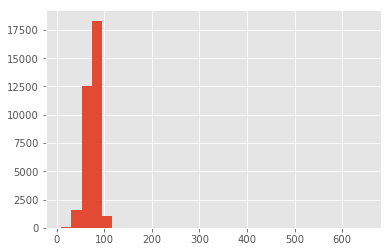

In [102]:
df['tmax_7days'].hist(bins=30)

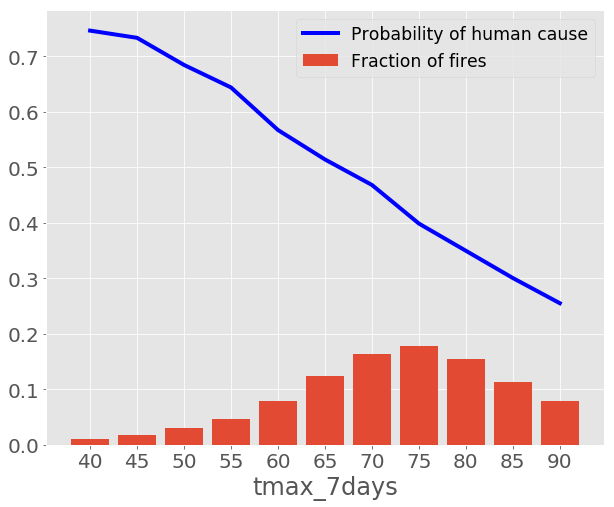

In [103]:
fig, ax = plt.subplots(figsize=(10,8))

tmax7_bins = np.arange(40,100,5)
_ = plot.univariate_binned_plot(tmax7_bins,'tmax_7days', ax, df)

#ax.set_title('Probability of Human Cause vs. Daily Maximum Temperature', fontsize=24)
#ax.set_xlabel('Maximum Temperature', fontsize=20)
#fig.savefig('images/tmax_univariate')

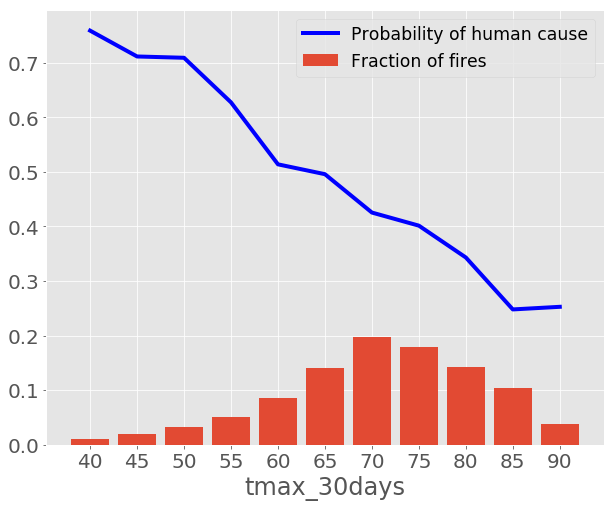

In [101]:
fig, ax = plt.subplots(figsize=(10,8))

tmax30_bins = np.arange(40,100,5)
_ = plot.univariate_binned_plot(tmax30_bins,'tmax_30days', ax, df)

#ax.set_title('Probability of Human Cause vs. Daily Maximum Temperature', fontsize=24)
#ax.set_xlabel('Maximum Temperature', fontsize=20)
#fig.savefig('images/tmax_univariate')

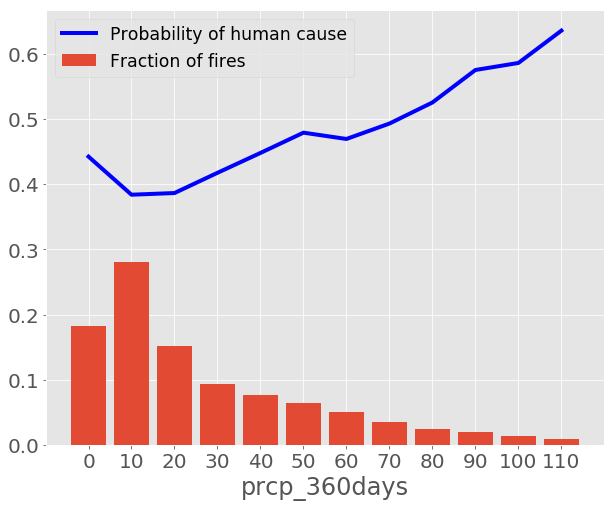

In [89]:
fig, ax = plt.subplots(figsize=(10,8))

prcp360_bins = np.arange(0,130,10)
_ = plot.univariate_binned_plot(prcp360_bins,'prcp_360days', ax, df)

#ax.set_title('Probability of Human Cause vs. Daily Maximum Temperature', fontsize=24)
#ax.set_xlabel('Maximum Temperature', fontsize=20)
#fig.savefig('images/tmax_univariate')

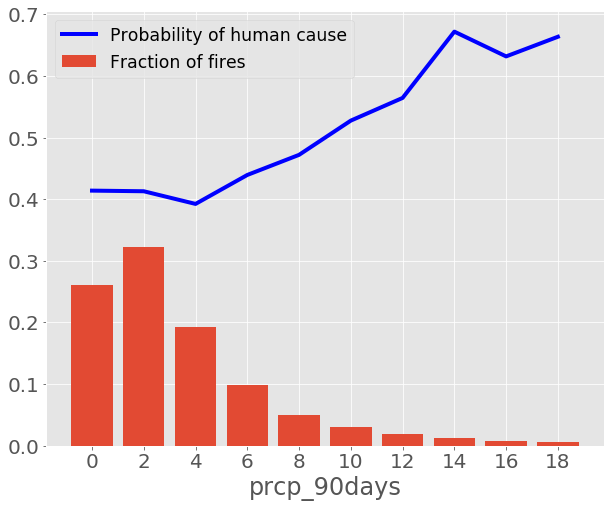

In [77]:
fig, ax = plt.subplots(figsize=(10,8))

prcp90_bins = np.arange(0,22,2)
_ = plot.univariate_binned_plot(prcp90_bins,'prcp_90days', ax, df)

#ax.set_title('Probability of Human Cause vs. Daily Maximum Temperature', fontsize=24)
#ax.set_xlabel('Maximum Temperature', fontsize=20)
#fig.savefig('images/tmax_univariate')


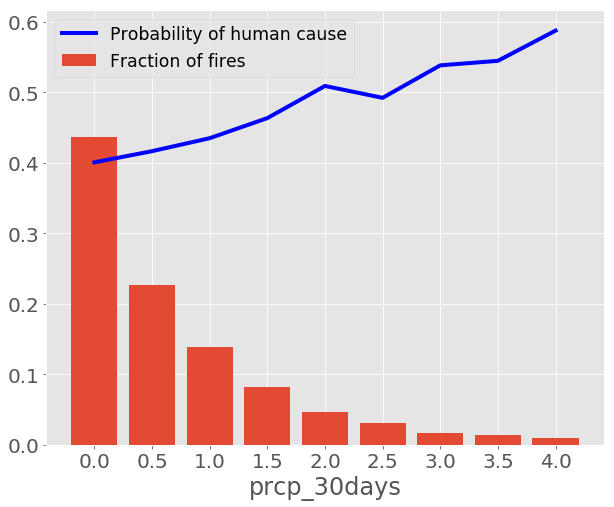

In [82]:
fig, ax = plt.subplots(figsize=(10,8))

prcp30_bins = np.arange(0,5,0.5)
_ = plot.univariate_binned_plot(prcp30_bins,'prcp_30days', ax, df)

#ax.set_title('Probability of Human Cause vs. Daily Maximum Temperature', fontsize=24)
#ax.set_xlabel('Maximum Temperature', fontsize=20)
#fig.savefig('images/tmax_univariate')


### Model test

In [104]:
pipeline.split_final_test("data/engineered_features.csv", "data/final_train_set.csv", "data/final_test_set.csv")

In [107]:
train = pd.read_csv("data/final_train_set.csv")

In [110]:
train['fire_year'].max()

2014

In [105]:
features = ["discovery_doy", "fire_size", "latitude_x",
                     "longitude_x", "elevation", "prcp", "snow", "tmax", "tmin",
                     "prcp_30days", "prcp_90days", "prcp_120days", "prcp_360days",
                      "tmax_30days", "tmax_7days"]

In [134]:
model = Model('gbc', n_estimators=600, max_depth=4)

In [112]:
X, y = pipeline.get_model_features('data/final_train_set.csv', features, 'cause_group', 'human')

subsample=0.5, max_depth=4

In [133]:
loss, loss_optimal, staged_loss, optimal_n_trees = model.cross_validate(5, X, y, True)

fold: 1, optimal number of trees: 576,                 log-loss at n_optimal: 0.55, final log-loss: 0.56
fold: 2, optimal number of trees: 371,                 log-loss at n_optimal: 0.55, final log-loss: 0.56
fold: 3, optimal number of trees: 479,                 log-loss at n_optimal: 0.56, final log-loss: 0.56
fold: 4, optimal number of trees: 543,                 log-loss at n_optimal: 0.56, final log-loss: 0.57
fold: 5, optimal number of trees: 451,                 log-loss at n_optimal: 0.55, final log-loss: 0.56


max_depth=5

In [126]:
loss, loss_optimal, staged_loss, optimal_n_trees = model.cross_validate(5, X, y, True)

fold: 1, optimal number of trees: 369,                 log-loss at n_optimal: 0.55, final log-loss: 0.55
fold: 2, optimal number of trees: 323,                 log-loss at n_optimal: 0.55, final log-loss: 0.55
fold: 3, optimal number of trees: 339,                 log-loss at n_optimal: 0.55, final log-loss: 0.56
fold: 4, optimal number of trees: 475,                 log-loss at n_optimal: 0.56, final log-loss: 0.56
fold: 5, optimal number of trees: 476,                 log-loss at n_optimal: 0.55, final log-loss: 0.55


max_depth=4

In [124]:
loss, loss_optimal, staged_loss, optimal_n_trees = model.cross_validate(5, X, y, True)

fold: 1, optimal number of trees: 642,                 log-loss at n_optimal: 0.55, final log-loss: 0.55
fold: 2, optimal number of trees: 537,                 log-loss at n_optimal: 0.55, final log-loss: 0.55
fold: 3, optimal number of trees: 616,                 log-loss at n_optimal: 0.56, final log-loss: 0.56
fold: 4, optimal number of trees: 594,                 log-loss at n_optimal: 0.56, final log-loss: 0.56
fold: 5, optimal number of trees: 665,                 log-loss at n_optimal: 0.55, final log-loss: 0.55


max_dept=3

In [122]:
loss, loss_optimal, staged_loss, optimal_n_trees = model.cross_validate(5, X, y, True)

fold: 1, optimal number of trees: 836,                 log-loss at n_optimal: 0.56, final log-loss: 0.56
fold: 2, optimal number of trees: 1026,                 log-loss at n_optimal: 0.55, final log-loss: 0.56
fold: 3, optimal number of trees: 833,                 log-loss at n_optimal: 0.56, final log-loss: 0.57
fold: 4, optimal number of trees: 1361,                 log-loss at n_optimal: 0.56, final log-loss: 0.56
fold: 5, optimal number of trees: 909,                 log-loss at n_optimal: 0.55, final log-loss: 0.56


first model

In [180]:
model.cross_validate(5, X, y)

fold: 1, log-loss: 0.57
fold: 2, log-loss: 0.58
fold: 3, log-loss: 0.57
fold: 4, log-loss: 0.57
fold: 5, log-loss: 0.57


([0.57487490879965486,
  0.57638408696674803,
  0.57029281706720669,
  0.57390894421648131,
  0.57319458755102526],
 [],
 [],
 [])

In [142]:
mean = y.mean()

In [145]:
mean_pred = np.array([mean]*y.shape[0])

In [148]:
log_loss(y, mean_pred)

0.68389807489019738

### Validation

In [136]:
model = Model('gbc', n_estimators=600, max_depth=4)

In [127]:
X_test, y_test = pipeline.get_model_features('data/final_test_set.csv', features, 'cause_group', 'human')

In [128]:
preds = model.predict(X_test)

In [130]:
from sklearn.metrics import roc_auc_score

In [131]:
roc_auc_score(y_test, preds)

0.76496034459182272

In [1]:
import simplejson
import sys
import yaml


In [2]:
yaml.dump('config.json')

'config.json\n...\n'

In [9]:
with open ('config.json') as f: 
    with open ('config.yaml', 'w') as f2:
        f2.write(yaml.dump(simplejson.load(f), default_flow_style=False))


In [11]:
fire_raw = pd.read_csv('data/WA_fires.csv')

In [12]:
fire_raw.head()

,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,COUNTY,FIPS_CODE,FIPS_NAME
0,2005,2453540.5,170,1430.0,1.0,Lightning,2453541.5,171.0,1400.0,0.3,B,46.220833,-117.785000,WA,27,27.0,Grays Harbor
1,2005,2453567.5,197,1354.0,4.0,Campfire,2453567.5,197.0,1600.0,0.1,A,46.080556,-117.890833,WA,13,13.0,Columbia
2,2005,2453516.5,146,950.0,6.0,Railroad,2453516.5,146.0,1020.0,0.1,A,45.665000,-121.203611,WA,39,39.0,Klickitat
3,2005,2453585.5,215,1236.0,9.0,Miscellaneous,2453585.5,215.0,1402.0,0.1,A,48.356667,-117.060833,WA,51,51.0,Pend Oreille
4,2005,2453555.5,185,2002.0,6.0,Railroad,2453555.5,185.0,2010.0,0.1,A,45.699444,-121.413611,WA,39,39.0,Klickitat


In [17]:
test_data = fire_raw.sample(5)

In [26]:
pd.read_csv('data/test_clean.csv')

,fire_year,discovery_date,discovery_doy,discovery_time,stat_cause_code,stat_cause_descr,cont_date,cont_doy,cont_time,fire_size,...,prcp,snow,snwd,tavg,tmax,tmin,tobs,month_y,year,doy
0,1993,2449120.5,133,1701.0,5.0,Debris Burning,2449120.5,133.0,1930.0,30.0,...,0.00,0.0,0.0,NaN,91.0,56.0,63.0,5,1993,133
1,2010,2455406.5,210,NaN,1.0,Lightning,NaN,NaN,NaN,0.1,...,1.31,0.0,0.0,NaN,81.0,44.0,NaN,7,2010,210
2,1992,2448906.5,285,NaN,9.0,Miscellaneous,NaN,NaN,NaN,5.0,...,0.00,0.0,0.0,NaN,64.0,50.0,59.0,10,1992,285
3,1998,2451056.5,243,NaN,9.0,Miscellaneous,NaN,NaN,NaN,0.1,...,0.00,0.0,0.0,NaN,100.0,52.0,78.0,8,1998,243
4,2014,2456871.5,214,1742.0,11.0,Powerline,2456879.5,222.0,1800.0,0.5,...,0.00,0.0,0.0,NaN,90.0,57.0,NaN,8,2014,214


In [29]:
predictions = pd.read_csv('data/predictions.csv')

In [31]:
predictions.head(2).to_dict()

{'date_start': {0: '1993-05-13', 1: '1992-10-11'},
 'latitude_x': {0: 47.8582, 1: 47.6031},
 'longitude_x': {0: -118.0594, 1: -120.19421000000001},
 'prediction': {0: 0.7135056665999614, 1: 0.6140373672145029}}

In [135]:
model.final_model(X,y)

In [142]:
one_df = pd.read_csv('data/temp_one_fire.csv', header=None)

In [150]:
one_df

,id,date,latitude,longitude,county,probability,area,return
0,123,2008-06-28,48,-120,King,0.30,100,10726


In [144]:
one_df.columns = ['id', 'date', 'latitude', 'longitude', 'county',
                          'probability', 'area', 'return']

In [149]:
one_df['return'] = one_df['return'].map(lambda x:"{:.0f}".format(x))

### Maps

In [175]:
df_stations = pd.read_csv('data/station_coordinates.csv')

In [176]:
df_stations.head()

,station,latitude,longitude
0,CA001018611,48.0333,-123.3333
1,CA001102420,49.0000,-123.0833
2,CA001135126,49.0000,-118.7667
3,US1WAAD0002,46.7849,-119.1915
4,US1WAAD0003,46.8111,-119.1549


In [168]:
washington = gpd.read_file('images/washington/tl_2013_53_cousub.shp')

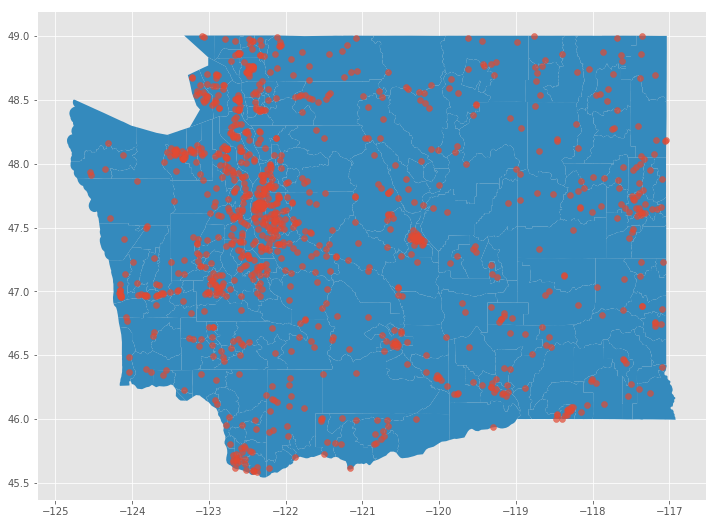

In [178]:
fig, ax = plt.subplots(figsize=(12,9))
washington.plot(ax=ax)
ax.scatter(df_stations.longitude, df_stations.latitude, alpha = 0.7)

In [ ]:
fig, ax = plt.subplots(figsize=(12,9))
washington.plot(ax=ax)
ax.scatter(df_stations.longitude, df_stations.latitude, alpha = 0.7)

In [179]:
df.head()

,fire_year,discovery_date,discovery_doy,discovery_time,stat_cause_code,stat_cause_descr,cont_date,cont_doy,cont_time,fire_size,...,tobs,prcp_90days,cause_group,prcp_30days,prcp_120days,prcp_360days,tmax_30days,tmax_7days,tmax_30days_binned,tmax_7days_binned
0,2005,2453540.5,170,1430.0,1.0,Lightning,2453541.5,171.0,1400.0,0.3,...,56.0,15.40,other,1.80,16.60,43.20,58.833333,60.428571,"(55, 60]","(60, 65]"
1,2005,2453567.5,197,1354.0,4.0,Campfire,2453567.5,197.0,1600.0,0.1,...,50.0,7.50,human,1.80,17.20,43.60,67.666667,70.714286,"(65, 70]","(70, 75]"
2,2005,2453516.5,146,950.0,6.0,Railroad,2453516.5,146.0,1020.0,0.1,...,NaN,4.48,other,2.15,4.92,10.56,70.233333,73.714286,"(70, 75]","(70, 75]"
3,2005,2453585.5,215,1236.0,9.0,Miscellaneous,2453585.5,215.0,1402.0,0.1,...,83.0,6.73,other,1.42,7.54,25.31,86.100000,92.285714,"(85, 90]","(90, 95]"
4,2005,2453555.5,185,2002.0,6.0,Railroad,2453555.5,185.0,2010.0,0.1,...,68.0,5.67,other,0.51,6.13,18.09,69.033333,73.857143,"(65, 70]","(70, 75]"
